In [4]:
import numpy
%matplotlib notebook
from matplotlib import pyplot

In [5]:
from soapy import atmosphere, WFS, confParse
from aotools import circle


In [6]:
SOAPY_CONF = "conf/test_conf.py"

True
4096
10.0
95
pupilSize:64
simSize:76
95
4.0
[    0  5000 10000 15000]


<IPython.core.display.Javascript object>


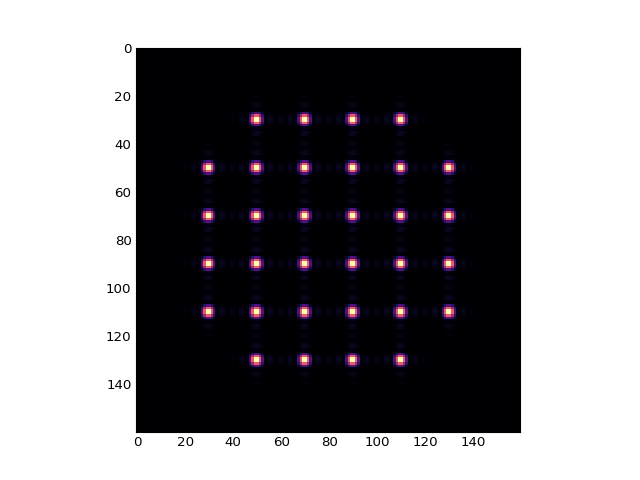

In [15]:
# Initialise the WFS
config = confParse.Configurator(SOAPY_CONF)
config.loadSimParams()

config.tel.telDiam=1.
config.wfss[0].wavelength = 500e-9
config.atmos.scrnNo = 1
config.wfss[0].subapFOV = 4.
config.wfss[0].subapThreshold = 1.
config.sim.pupilSize = 64
config.atmos.wholeScrnSize = 2**12
config.atmos.windDirs[0] = 10
config.atmos.windSpeeds[0] = 50
config.atmos.subHarmonics = True
#config.sim.simOversize = 1

config.calcParams()

mask = circle.circle(config.sim.pupilSize/2., config.sim.simSize)

wfs = WFS.ShackHartmann(
        config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)

print(config.atmos.subHarmonics)
print(config.atmos.wholeScrnSize)
print(wfs.subapFOVSpacing)
print(wfs.scaledEFieldSize)
print("pupilSize:{}".format(config.sim.pupilSize))
print("simSize:{}".format(config.sim.simSize))
print(wfs.phaseSize)
print(config.wfss[0].subapFOV)
print(config.atmos.scrnHeights)
pyplot.figure()
pyplot.imshow(wfs.wfsDetectorPlane)


In [10]:
# Make a set of phase screens to test
N_ITERS = 1000
N_SCRNS = 4

NR0 = 5
R0s = numpy.linspace(0.05, 0.5, NR0)

In [16]:
# Conversion from slopes into radians
wfsPxlScale_asec = float(config.wfss[0].subapFOV)/config.wfss[0].pxlsPerSubap
wfsPxlScale_deg = wfsPxlScale_asec/3600.
wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
print(wfsPxlScale_rad)

9.69627362219e-07


In [17]:
slopes = numpy.zeros((NR0, N_SCRNS*N_ITERS, wfs.activeSubaps))
for ir0, r0 in enumerate(R0s):
    print('Test R0: {}'.format(r0))
    config.atmos.r0 = r0
    config.atmos.randomScrns = False
    for iscrn in range(N_SCRNS):
        atmos = atmosphere.atmos(config.sim, config.atmos)
        print('Made screen - starting run')
        for i in range(N_ITERS):
            slopes[ir0, iscrn*N_ITERS + i] = wfs.frame(atmos.moveScrns())[:wfs.activeSubaps]

Test R0: 0.05
Turbulence summary @ 500 nm:
| r0 = 0.05 m (2.06" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 0.31 ms
Made screen - starting run
Turbulence summary @ 500 nm:
| r0 = 0.05 m (2.06" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 0.31 ms
Made screen - starting run
Turbulence summary @ 500 nm:
| r0 = 0.05 m (2.06" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 0.31 ms
Made screen - starting run
Turbulence summary @ 500 nm:
| r0 = 0.05 m (2.06" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 0.31 ms
Made screen - starting run
Test R0: 0.1625
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.63" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 1.02 ms
Made screen - starting run
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.63" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 1.02 ms
Made screen - starting run
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.63" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 1.02 ms
Made screen - starting run
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.63" seeing)
| Vbar_5/3 = 50.00 m/s
| tau0 = 1.02 

In [18]:
# Convert slopes to rad
slopes_rad = slopes*wfsPxlScale_rad
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(NR0)
for i in range(NR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 5e-07
Subap Diameter (m): 0.125


<IPython.core.display.Javascript object>


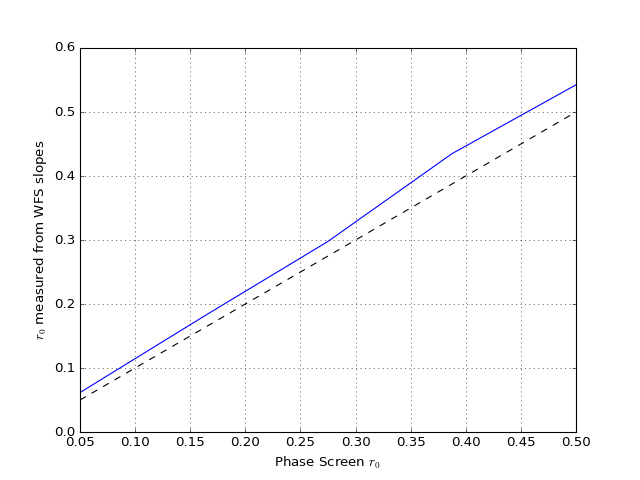

In [19]:
pyplot.figure()
pyplot.plot(R0s, measuredR0)
pyplot.plot(R0s, R0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

In [10]:
# Perhaps this is something to do with WFS linearity? Would see a change with pixel scale if so
nFovs = 5
subapFovs = numpy.linspace(3, 10, nFovs)
nScrns = 100

# Alternative way, which uses Soapy atmosphere
config.atmos.scrnNo = 1

slopes = numpy.zeros((nFovs, nR0, nScrns, wfs.activeSubaps))

for ifov, fov in enumerate(subapFovs):
    config.wfss[0].subapFOV = fov
    wfs = WFS.ShackHartmann(
            config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)
    for ir, r0 in enumerate(r0s):
        config.atmos.r0 = r0
        config.atmos.randomScrns = True
        atmos = atmosphere.atmos(config.sim, config.atmos)
        for i in range(nScrns):
            slopes[ifov, ir, i] = wfs.frame(atmos.moveScrns())[:wfs.activeSubaps]

NameError: name 'nR0' is not defined

In [ ]:
wfsPxlScales_rad = []
slopes_rad = slopes.copy()
# Turn slopes into radians
for ifov, fov in enumerate(subapFovs):
    wfsPxlScale_asec = float(fov)/config.wfss[0].pxlsPerSubap
    wfsPxlScale_deg = wfsPxlScale_asec/3600.
    wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
    
    slopes_rad[ifov] *= wfsPxlScale_rad
    print(wfsPxlScale_rad)

In [ ]:
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros((nFovs, nR0))
for ifov, fov in enumerate(subapFovs):
    for i in range(nR0):
        sVar = slopes_rad[ifov, i].var(0).mean()
        measuredR0[ifov, i] = ((0.358*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

In [ ]:
pyplot.figure()
pyplot.plot(r0s, r0s, color="k", linestyle="--", label="Expected")

pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

for ifov, fov in enumerate(subapFovs):
    pxlScale = float(fov)/config.wfss[0].pxlsPerSubap
    pyplot.plot(r0s, measuredR0[ifov], label="Pixel Scale: {:.2f}\" ".format(pxlScale))
    
pyplot.legend(loc=0)